In [17]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lropt
import sys
sys.path.append('..')
from utils import plot_tradeoff,plot_iters, plot_contours, plot_contours_line
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
# plt.rcParams.update({
#     "text.usetex":True,
    
#     "font.size":24,
#     "font.family": "serif"
# })

### generate data

In [18]:
# Formulate constants
n = 2
N = 2000
eps_list = np.linspace(0.5, 2.5, 10)
k_init = np.array([4.,5.])

def gen_demand_cor(N,seed,x1, x2):
    np.random.seed(seed)
    sig = np.eye(2)
    mu = np.array((6,7))
    points_list = []
    for i in range(N):
        mu_shift = -0.4*x1 - 0.1*x2
        newpoint = np.random.multivariate_normal(mu+mu_shift,sig)
        points_list.append(newpoint)
    return np.vstack(points_list)

In [19]:
s = 1
# in order for scenario to make sense, generate only 20 contexts
np.random.seed(s)
num_context = 20
num_reps = int(N/num_context)
init_k_data = np.maximum(0.5,k_init + np.random.normal(0,3,(num_context,n)))
init_p_data = init_k_data + np.maximum(0,np.random.normal(0,3,(num_context,n)))
p_data = np.repeat(init_p_data,num_reps,axis=0)
k_data = np.repeat(init_k_data,num_reps,axis=0)

# uncertain data depends on the contexts
seed = 5
init_data = [gen_demand_cor(num_reps,seed=seed,x1=init_p_data[i],x2=init_k_data[i]) for i in range(num_context)] 
data = np.vstack(init_data)
test_p = 0.5
valid_p = 0.2

# split dataset
test_indices = np.random.choice(num_reps,int((test_p)*num_reps), replace=False)
# test_indices = testv_indices[:int((test_p)*num_reps)]
# valid_indices = testv_indices[int((test_p)*num_reps):]
train_indices = [i for i in range(num_reps) if i not in test_indices]

train = np.array([init_data[j][i] for i in train_indices for j in range(num_context)])
test = np.array([init_data[j][i] for i in test_indices for j in range(num_context)])
# valid = np.array([init_data[j][i] for i in test_indices for j in range(num_context)])

### create lropt problem

In [20]:
# Formulate uncertainty set
u = lropt.UncertainParameter(n,
                        uncertainty_set=lropt.Ellipsoidal(
                                                    data=data))
# Formulate the Robust Problem
x_r = cp.Variable(n)
t = cp.Variable()
k = lropt.ContextParameter(2, data=k_data)
p = lropt.ContextParameter(2, data=p_data)
p_x = cp.Variable(n)
objective = cp.Minimize(t)
constraints = [lropt.max_of_uncertain([-p[0]*x_r[0] - p[1]*x_r[1],-p[0]*x_r[0] - p_x[1]*u[1], -p_x[0]*u[0] - p[1]*x_r[1], -p_x[0]*u[0]- p_x[1]*u[1]]) + k@x_r <= t]
constraints += [p_x == p]
constraints += [x_r >= 0]

eval_exp = k@x_r + cp.maximum(-p[0]*x_r[0] - p[1]*x_r[1],-p[0]*x_r[0] - p[1]*u[1], -p[0]*u[0] - p[1]*x_r[1], -p[0]*u[0]- p[1]*u[1]) 

prob = lropt.RobustProblem(objective, constraints,eval_exp = eval_exp)

### train lropt problem

In [21]:
num_iters = 501
initn = sc.linalg.sqrtm(np.cov(train.T))
init_bvaln = np.mean(train, axis=0)

# Train A and b
from lropt import Trainer
trainer = Trainer(prob)
trainer_settings = lropt.TrainerSettings()
trainer_settings.lr=0.0001
trainer_settings.num_iter=num_iters  # number of training iterations 
trainer_settings.optimizer="SGD"
trainer_settings.seed=5
trainer_settings.init_A=initn
trainer_settings.init_b=init_bvaln
trainer_settings.init_rho = 1
trainer_settings.init_lam= 1
trainer_settings.init_mu= 1
trainer_settings.mu_multiplier=1.001
trainer_settings.test_percentage = test_p
trainer_settings.save_history = True
trainer_settings.lr_step_size = 50  # scheduler - every 50 steps, multiply by lr_gamma
trainer_settings.lr_gamma = 0.5
trainer_settings.random_init = False  # if true, initializes at random sets
trainer_settings.num_random_init = 5
trainer_settings.parallel = False
trainer_settings.eta= 0.3
trainer_settings.kappa = 0
trainer_settings.contextual = True
trainer_settings.obj_scale = 5
trainer_settings.max_iter_line_search = 200
trainer_settings.line_search = True
trainer_settings.predictor = lropt.LinearPredictor(predict_mean = True,pretrain = True,epochs = 20,lr = 0.001,knn_cov=True,n_neighbors=20)
trainer_settings.max_batch_size = 200
trainer_settings.batch_percentage = 0.2
trainer_settings.validate_percentage = valid_p
trainer_settings.test_frequency = 500
trainer_settings.validate_frequency = 100
# trainer_settings.init_weight = init_weight  # initialization with ltsq pred
# trainer_settings.init_bias = init_bias
result = trainer.train(settings=trainer_settings)
df = result.df
result.df.to_csv('linear_training.csv')
result.df_test.to_csv('linear_testing.csv')
A_fin = result.A
b_fin = result.b

Training: 100%|█████████▉| 500/501 [04:41<00:00,  1.78it/s, loss=-5.20e+00, viol=1.20e+00]


In [22]:
# trained linear NN
result_grid2 = trainer.grid(rholst=result.rho*eps_list/trainer_settings.init_rho,init_A=A_fin, init_b=b_fin, seed=s,init_alpha=0., test_percentage=test_p,quantiles = (0.3,0.7), contextual = True, predictor = result._predictor)
dfgrid2 = result_grid2.df
dfgrid2.to_csv('linear_trained_grid.csv')

In [23]:
# no training (steps = 1, look at initalized set)
trainer_settings.predictor = lropt.LinearPredictor(predict_mean = True,pretrain = True,epochs = 100, lr = 0.001)
trainer_settings.initialize_predictor = True
trainer_settings.num_iter = 1 
trainer_settings.init_rho = 1
result2 = trainer.train(settings=trainer_settings)
df2 = result2.df
A_fin2 = result2.A
b_fin2 = result2.b

# untrained linear NN
result_grid3 = trainer.grid(rholst=eps_list,init_A=A_fin2, init_b=b_fin2, seed=s,init_alpha=0., test_percentage=test_p,quantiles = (0.3,0.7), contextual = True, predictor = result2._predictor)
dfgrid3 = result_grid3.df
dfgrid3.to_csv('linear_untrained_grid.csv')

Training:   0%|          | 0/1 [00:03<?, ?it/s]


In [24]:
# no training (steps = 1, look at initalized NN set)
trainer_settings.predictor = lropt.NNPredictor(predict_mean = True,pretrain= True,epochs = 20,lr = 0.001)
trainer_settings.initialize_predictor = True
trainer_settings.num_iter = 1
trainer_settings.init_rho = 1
result3 = trainer.train(settings=trainer_settings)
df3 = result3.df
A_fin3= result3.A
b_fin3 = result3.b

# untrained linear NN
result_grid4 = trainer.grid(rholst=eps_list,init_A=A_fin3, init_b=b_fin3, seed=s,init_alpha=0., test_percentage=test_p,quantiles = (0.3,0.7), contextual = True, predictor = result3._predictor)
dfgrid4 = result_grid4.df
dfgrid4.to_csv('linear_untrained_grid.csv')

Training:   0%|          | 0/1 [00:03<?, ?it/s]


In [25]:
df_valid, df_test = trainer.compare_predictors(settings=trainer_settings,predictors_list=[result._predictor,result2._predictor,result3._predictor], rho_list=[result.rho,result2.rho,result3.rho])

Training:   0%|          | 0/1 [00:04<?, ?it/s]


### analyze results

In [26]:

def plot_iters(dftrain,dftest, title, steps=2000, logscale=True,kappa=0):
    # plt.rcParams.update({
    #     "text.usetex": True,

    #     "font.size": 22,
    #     "font.family": "serif"
    # })
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 3))

    # ax1.plot(dftrain["Violation_val"][:steps],
    #          label="Out-of-sample empirical CVaR")
    ax1.plot(dftrain["Violations_train"][:steps],
             label="In-sample empirical CVaR", linestyle="--")
    ax1.plot(np.arange(0,num_iters, trainer_settings.validate_frequency),dftest["Violations_validate"][:steps],
             label="out-of-sample empirical CVaR", linestyle="--")

    ax1.set_xlabel("Iterations")
    ax1.hlines(xmin=0, xmax=dftrain["Violations_train"][:steps].shape[0],
               y=kappa, linestyles="--", color="black", label=f"Target threshold: {kappa}")
    ax1.legend()
    ax2.plot(dftrain["Train_val"][:steps], label="In-sample objective value")
    ax2.plot(np.arange(0,num_iters, trainer_settings.validate_frequency),dftest["Validate_val"][:steps], label="Out-of-sample objective value")

    ax2.set_xlabel("Iterations")
    ax2.ticklabel_format(style="sci", axis='y',
                         scilimits=(0, 0), useMathText=True)
    ax2.legend()
    if logscale:
        ax1.set_xscale("log")
        ax2.set_xscale("log")
    plt.savefig(title+"_iters.pdf", bbox_inches='tight')

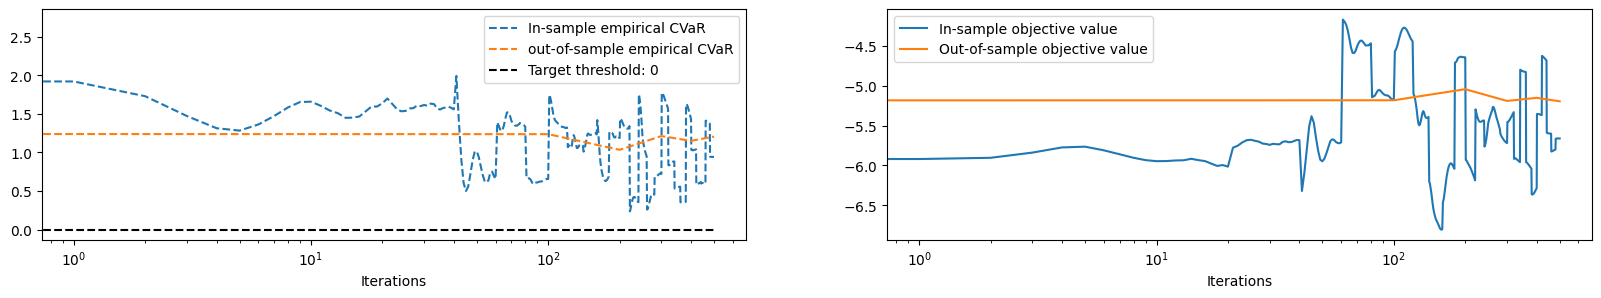

In [27]:
import matplotlib
import matplotlib.pyplot as plt
plot_iters(result.df,result.df_validate, steps=num_iters, title="training",kappa=trainer_settings.kappa)

### plot tradeoff over radius

In [28]:
# Grid search epsilon
# mean variance set
result_grid = trainer.grid(rholst=eps_list, init_A=initn,
                    init_b=init_bvaln, seed=s,
                    init_alpha=0., test_percentage=test_p, validate_percentage = valid_p, quantiles = (0.3, 0.7))
dfgrid = result_grid.df
dfgrid.to_csv('mean_var_grid.csv')

In [29]:
epslst =eps_list
prob_list = np.array([0.,0.01,0.05,0.1])
inds_standard = []
inds_reshaped = []
inds_untrained = []
inds_untrained_lin = []
for i in prob_list:
    inds_standard.append(np.absolute(np.mean(np.vstack(dfgrid['Avg_prob_test']),axis = 1)-i).argmin())
    inds_reshaped.append(np.absolute(np.mean(np.vstack(dfgrid2['Avg_prob_test']),axis = 1)-i).argmin())
    inds_untrained.append(np.absolute(np.mean(np.vstack(dfgrid3['Avg_prob_test']),axis = 1)-i).argmin())
    inds_untrained_lin.append(np.absolute(np.mean(np.vstack(dfgrid4['Avg_prob_test']),axis = 1)-i).argmin())

### scenario approach

In [30]:
def calc_eval(x,p,k,u,t):
  val = 0
  vio = 0
  for i in range(u.shape[0]):
    val_cur = k@x + np.max([-p[0]*x[0] - p[1]*x[1],-p[0]*x[0] - p[1]*u[i][1], -p[0]*u[i][0] - p[1]*x[1], -p[0]*u[i][0]- p[1]*u[i][1]]) 
    val+= val_cur
    vio += (val_cur >= t)
  return val/u.shape[0], vio/u.shape[0]
context_evals = 0
context_probs = 0
# solve for each context and average
for context in range(num_context):
    u = lropt.UncertainParameter(n,
                            uncertainty_set=lropt.Scenario(
                                                        data=init_data[context][train_indices]))
    x_s = cp.Variable(n)
    t1 = cp.Variable()
    k1= init_k_data[context]
    p1 = init_p_data[context]
    objective = cp.Minimize(t1)
    constraints = [lropt.max_of_uncertain([-p1[0]*x_s[0] - p1[1]*x_s[1],
                                            -p1[0]*x_s[0] - p1[1]*u[1],
                                            -p1[0]*u[0] - p1[1]*x_s[1],
                                              -p1[0]*u[0]- p1[1]*u[1]])
                                              + k1@x_s <= t1]
    constraints += [x_s >= 0]

    prob_sc = lropt.RobustProblem(objective, constraints)
    prob_sc.solve()
    eval, prob_vio = calc_eval(x_s.value, init_p_data[context], init_k_data[context],init_data[context][test_indices],t1.value)
    context_evals += eval
    context_probs += prob_vio
context_evals = context_evals/num_context
context_probs = context_probs/num_context
print(context_evals, context_probs)

-4.1714488636947245 0.15100000000000002


### nonrobust average

In [31]:
nonrob_evals = 0
nonrob_probs = 0
for context in range(num_context):
        u = lropt.UncertainParameter(n,
                                uncertainty_set=lropt.Scenario(
                                                            data=np.mean(init_data[context][train_indices],axis=0).reshape(1,2)))
        x_s = cp.Variable(n)
        t1 = cp.Variable()
        k1= init_k_data[context]
        p1 = init_p_data[context]
        objective = cp.Minimize(t1)
        constraints = [lropt.max_of_uncertain([-p1[0]*x_s[0] - p1[1]*x_s[1],
                                                -p1[0]*x_s[0] - p1[1]*u[1],
                                                -p1[0]*u[0] - p1[1]*x_s[1],
                                                  -p1[0]*u[0]- p1[1]*u[1]])
                                                  + k1@x_s <= t1]
        constraints += [x_s >= 0]

        prob_sc = lropt.RobustProblem(objective, constraints)
        prob_sc.solve()
      
        eval, prob_vio = calc_eval(x_s.value, init_p_data[context], init_k_data[context],init_data[context][test_indices],t1.value)
        nonrob_evals += eval
        nonrob_probs += prob_vio
nonrob_evals = nonrob_evals / (num_context)
nonrob_probs = nonrob_probs / (num_context)
print(nonrob_evals,nonrob_probs)

-4.447461114326421 0.8739999999999999


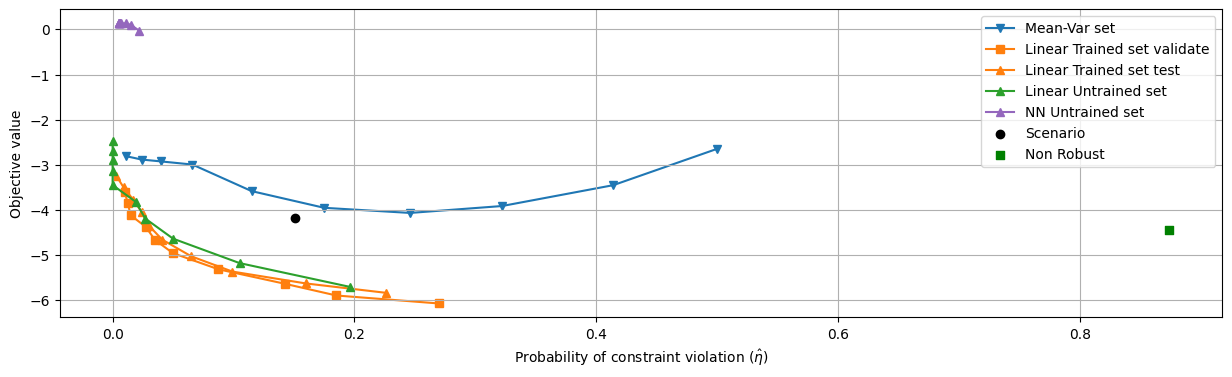

In [32]:
# indss = [5,9,13,18,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35]
# dfgrid, dfgrid2 = results_grid4[(16,0.3)]
beg1, end1 = 0, 100
beg2, end2 = 0, 100
plt.figure(figsize=(15, 4))
plt.plot(np.mean(np.vstack(dfgrid['Avg_prob_test']), axis=1)[beg1:end1], np.mean(np.vstack(
    dfgrid['Test_val']), axis=1)[beg1:end1], color="tab:blue", label=r"Mean-Var set", marker="v", zorder=0)
plt.plot(np.mean(np.vstack(dfgrid2['Avg_prob_validate']), axis=1)[beg2:end2], np.mean(np.vstack(
    dfgrid2['Validate_val']), axis=1)[beg2:end2], color="tab:orange", label="Linear Trained set validate", marker="s", zorder=1)
plt.plot(np.mean(np.vstack(dfgrid2['Avg_prob_test']), axis=1)[beg2:end2], np.mean(np.vstack(
    dfgrid2['Test_val']), axis=1)[beg2:end2], color="tab:orange", label="Linear Trained set test", marker="^", zorder=1)
plt.plot(np.mean(np.vstack(dfgrid3['Avg_prob_test']), axis=1)[beg2:end2], np.mean(np.vstack(
    dfgrid3['Test_val']), axis=1)[beg2:end2], color="tab:green", label="Linear Untrained set", marker="^", zorder=2)
plt.plot(np.mean(np.vstack(dfgrid4['Avg_prob_test']), axis=1)[beg2:end2], np.mean(np.vstack(
    dfgrid4['Test_val']), axis=1)[beg2:end2], color="tab:purple", label="NN Untrained set", marker="^", zorder=2)
plt.ylabel("Objective value")
plt.xlabel(r"Probability of constraint violation $(\hat{\eta})$")
# plt.ylim([-9, 0])
plt.grid()
plt.scatter(context_probs,context_evals, color = "black", label="Scenario")
plt.scatter(nonrob_probs,nonrob_evals, color = "green", marker = "s", label="Non Robust")
plt.legend()
plt.savefig("news_objective_vs_violations.pdf", bbox_inches='tight')

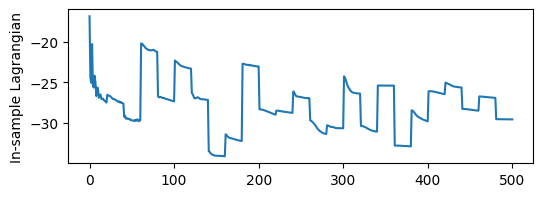

In [17]:
plt.figure(figsize=(6,2))
plt.plot(df["Lagrangian_val"])
plt.ylabel("In-sample Lagrangian")
plt.savefig("Lagrangian_"+".pdf", bbox_inches='tight')

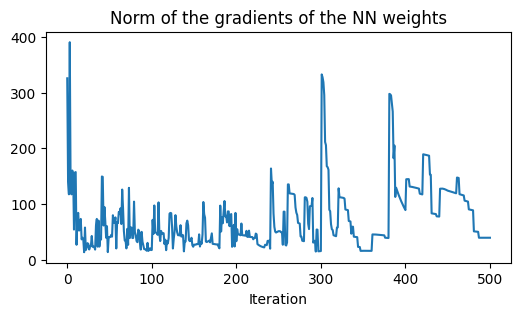

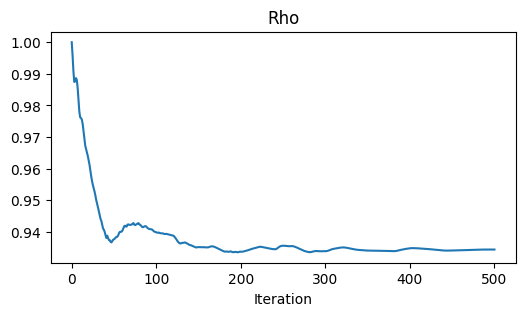

In [18]:
plt.figure(figsize = (6,3))
plt.plot(result.df["gradnorm"])
plt.xlabel("Iteration")
plt.title("Norm of the gradients of the NN weights")
plt.show()
plt.figure(figsize = (6,3))
plt.plot(result.df["Rho"])
plt.xlabel("Iteration")
plt.title("Rho")
plt.show()

It seems like for this seed, the reshaped set was able to get a slight improvement over the initialized set

In [19]:
K = 5
num_p = 50
offset = 5
x_min, x_max = np.min(train[:,0]) - offset, np.max(train[:,0]) + offset
y_min, y_max = np.min(train[:,1]) - offset, np.max(train[:,1]) + offset
X = np.linspace(x_min,x_max,num_p)
Y = np.linspace(y_min,y_max,num_p)
x,y = np.meshgrid(X,Y)

def gen_set(Amat,bvec,inds,K):
    fin_set = {}
    for ind in range(4):
        fin_set[ind] = {}
        for k_ind in range(K):
            fin_set[ind][k_ind] = np.zeros((num_p,num_p))
    for ind in range(4):
        for i in range(num_p):
            for j in range(num_p):
                u_vec = [x[i,j], y[i,j]]
                if K== 1:
                    fin_set[ind][0][i,j] = np.linalg.norm((1/eps_list[inds[ind]])*(Amat.T@np.linalg.inv(Amat@Amat.T))@(u_vec - bvec))
                else:
                    for k_ind in range(K):
                        fin_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds[ind]])*(Amat[k_ind].T@np.linalg.inv(Amat[k_ind]@Amat[k_ind].T))@(u_vec - bvec[k_ind]))
    return fin_set
                
Amat = result._a_history[-1]*result.rho
bvec = result._b_history[-1]
fin_set = gen_set(Amat,bvec,inds_reshaped,K)
init_set = gen_set(initn,init_bvaln,inds_standard,K=1)
Amat2 = result2._a_history[-1]*result2.rho
bvec2 = result2._b_history[-1]
untrained_set = gen_set(Amat2,bvec2,inds_untrained,K)
Amat3 = result3._a_history[-1]*result3.rho
bvec3 = result3._b_history[-1]
untrained_set2 = gen_set(Amat3,bvec3,inds_untrained_lin,K)

In [20]:
def plot_contours_line(x,y,set, prob_list, train, title, K=1):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3.5), constrained_layout= True)
    ax_lst = [ax1, ax2, ax3, ax4]
    np.random.seed(0)
    newtrain = np.random.choice(num_reps,size=15,replace=False)
    cur_ind = 0
    for axis in ax_lst:
        axis.set_title(r'$\hat{\eta}$' + ' = {}'.format(prob_list[cur_ind]))
        axis.set_xlabel(r"$u_1$")
        axis.set_ylabel(r"$u_2$")
        axis.scatter(np.mean(train,axis= 0)[0], np.mean(train,axis= 0)[1],color = ["tab:green"])
        for k_ind in range(num_context):
            axis.scatter(init_data[k_ind][:,0][newtrain],init_data[k_ind][:,1][newtrain],edgecolor = "black")
        for k_ind in range(K):
            axis.contour(x,y,set[cur_ind][k_ind], [1], colors = ["red"],linewidths = [2])
        cur_ind +=1
    fig.suptitle(title +" set", fontsize = 30)
    plt.savefig(title+"_set"+ ".pdf", bbox_inches='tight')

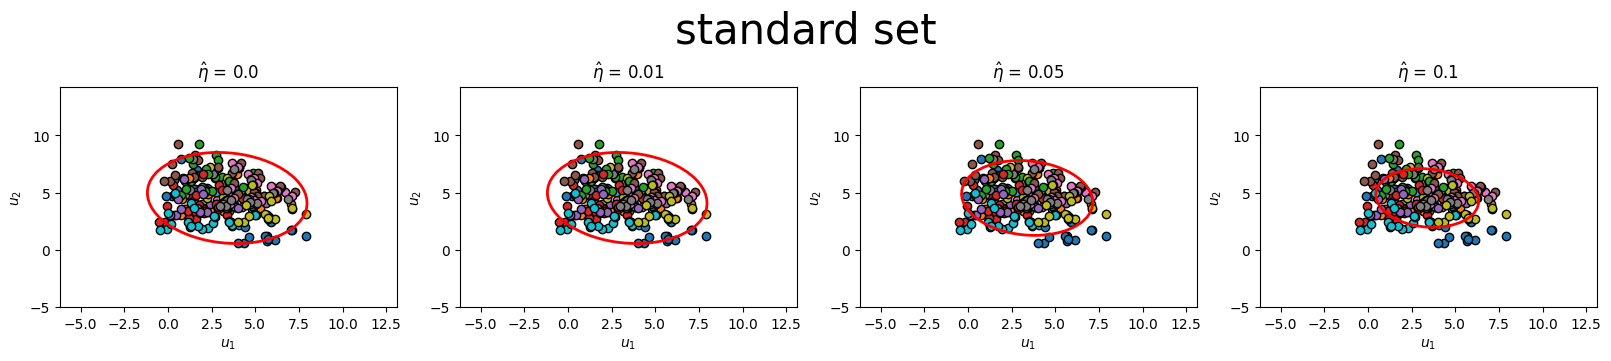

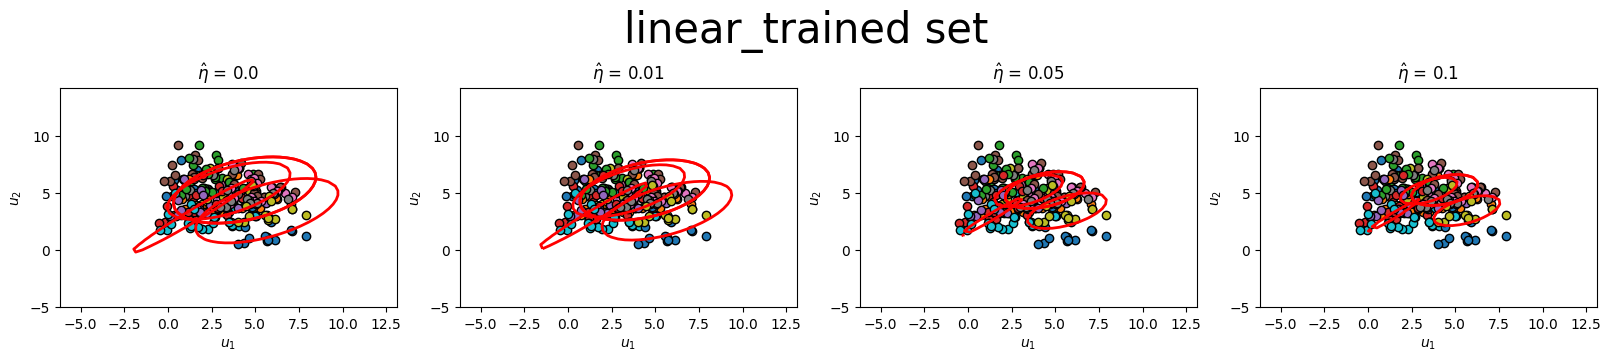

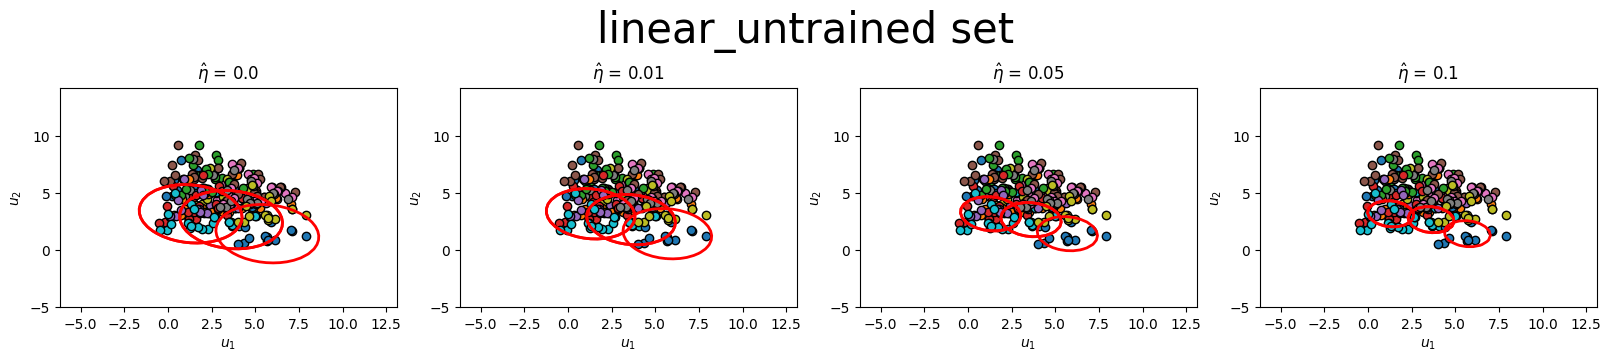

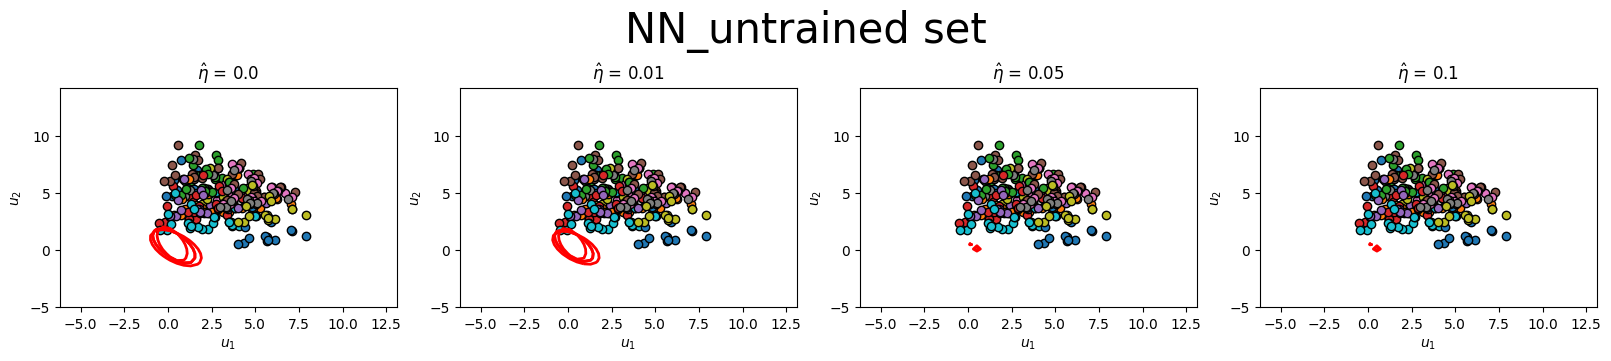

In [21]:
plot_contours_line(x,y,init_set,prob_list,train, "standard") 
plot_contours_line(x,y,fin_set, prob_list,train, "linear_trained", K=5)
plot_contours_line(x,y,untrained_set,prob_list,train, "linear_untrained", K=5)
plot_contours_line(x,y,untrained_set2,prob_list,train, "NN_untrained", K=5)